# ContinuousDP: Stochastic Optimal Growth Model

In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using PyPlot
using Random

In [2]:
alpha = 0.4
beta = 0.96
mu = 0
sigma = 0.1;

In [3]:
f(s, x) = log(x)
g(s, x, e) = (s - x)^alpha * e;

In [4]:
shock_size = 250
shocks = exp.(mu .+ sigma * randn(shock_size))
weights = fill(1/shock_size, shock_size);

In [5]:
grid_max = 4.
n = 30
s_min, s_max = 1e-5, grid_max
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (1.0e-5,) × (4.0,).
Basis families are Cheb


In [6]:
x_lb(s) = s_min
x_ub(s) = s;

In [7]:
ab = alpha * beta
c1 = log(1 - ab) / (1 - beta)
c2 = (mu + alpha * log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

# True optimal policy
c_star(y) = (1 - alpha * beta) * y

# True value function
v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y);

In [8]:
cdp = ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis);

In [9]:
@code_warntype ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis)

Variables
  #self#::Type{ContinuousDP}
  f::Core.Compiler.Const(f, false)
  g::Core.Compiler.Const(g, false)
  discount::Float64
  shocks::Array{Float64,1}
  weights::Array{Float64,1}
  x_lb::Core.Compiler.Const(x_lb, false)
  x_ub::Core.Compiler.Const(x_ub, false)
  basis::Basis{1,Tuple{ChebParams{Float64}}}
  interp::ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},LinearAlgebra.LU{Float64,Array{Float64,2}}}
  cdp::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}

Body::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}
1 ─     (interp = ContinuousDPs.Interp(basis))
│       (cdp = ContinuousDPs.ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, interp))
└──     return cdp


## First test

In [10]:
C_star = cdp.interp.Phi \ v_star.(cdp.interp.S)
Tv = Array{Float64}(undef, cdp.interp.length)
C = copy(C_star)
bellman_operator!(cdp, C, Tv);

In [11]:
@code_warntype bellman_operator!(cdp, C, Tv)

Variables
  #self#::Core.Compiler.Const(QuantEcon.bellman_operator!, false)
  cdp::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}
  C::Array{Float64,1}
  Tv@_4::Array{Float64,1}
  Tv@_5::Array{Float64,1}

Body::Array{Float64,1}
1 ─      (Tv@_5 = Tv@_4)
│   %2 = Base.getproperty(cdp, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:LinearAlgebra.Factorization where TM<:(AbstractArray{T,2} where T)
│   %3 = Base.getproperty(%2, :S)::Array{Float64,1}
│        (Tv@_5 = ContinuousDPs.s_wise_max!(cdp, %3, C, Tv@_5))
│   %5 = Base.getproperty(cdp, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:LinearAlgebra.Factorization where TM<:(AbstractArray{T,2} where T)
│   %6 = Base.getproperty(%5, :Phi_lu)::LinearAlgebra.Factorization
│        ContinuousDPs.ldiv!(C, %6, Tv@_5)
└──      return C


In [12]:
grid_size = 200
grid_y = collect(range(s_min, stop=s_max, length=grid_size))
V_approx = funeval(C, cdp.interp.basis, grid_y);

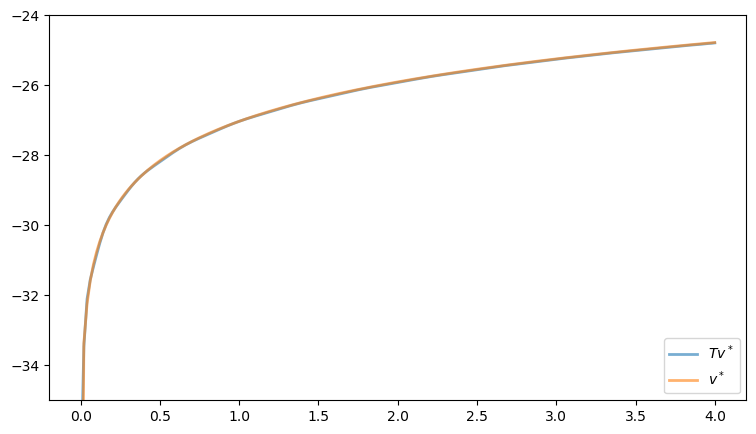

In [13]:
fig, ax = subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid_y, V_approx, lw=2, alpha=0.6, label=L"$Tv^*$")
ax.plot(grid_y, v_star.(grid_y), lw=2, alpha=0.6, label=L"$v^*$")
ax.legend(loc="lower right")
show()

In [14]:
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv);

  0.056858 seconds (850.27 k allocations: 50.511 MiB, 11.06% gc time)
  0.052167 seconds (830.13 k allocations: 49.318 MiB, 7.45% gc time)
  0.048592 seconds (773.45 k allocations: 45.955 MiB, 7.02% gc time)


In [15]:
s = 2.
@code_warntype ContinuousDPs._s_wise_max(cdp, s, C)

Variables
  #self#::Core.Compiler.Const(ContinuousDPs._s_wise_max, false)
  cdp::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}
  s::Float64
  C::Array{Float64,1}
  sp::Array{Float64,2}
  objective::ContinuousDPs.var"#objective#3"{ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)},Float64,Array{Float64,1},Array{Float64,2}}
  res::Any
  v::Float64
  x::Float64

Body::Tuple{Float64,Float64}
1 ─ %1  = Core.apply_type(ContinuousDPs.Array, ContinuousDPs.Float64)::Core.Compiler.Const(Array{Float64,N} where N, false)
│   %2  = Base.getproperty(cdp, :shocks)::Array{Float64,1}
│   %3  = ContinuousDPs.size(%2, 1)::Int64
│   %4  = ContinuousDPs.length(s)::Core.Compiler.Const(1, false)
│         (sp = (%1)(ContinuousDPs.undef, %3, %4))
│   %6  = ContinuousDPs.:(var"#objective#3")::Core.Compiler.Const(ContinuousDPs.var"#objective#3", false)
│   %7  = Core.typeof(cdp)::Core.Compiler.Const(ContinuousDP{1,Arr

In [16]:
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C);

  0.001168 seconds (18.29 k allocations: 1.087 MiB)
  0.001128 seconds (18.29 k allocations: 1.087 MiB)
  0.001003 seconds (18.29 k allocations: 1.087 MiB)


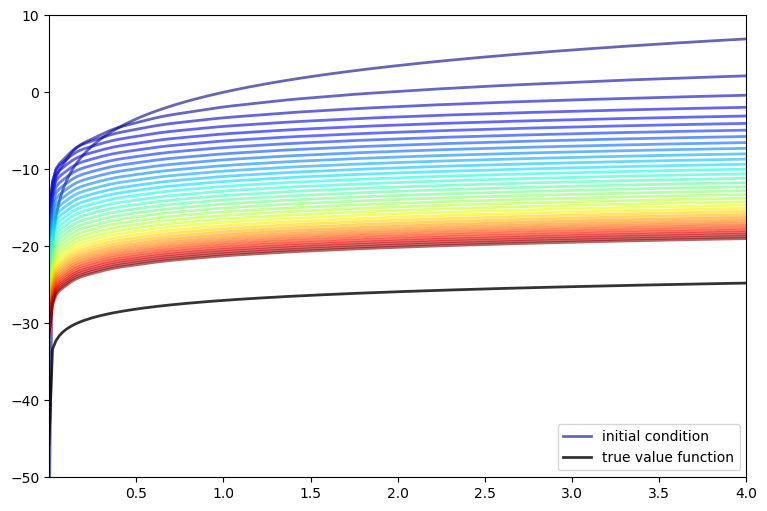

In [17]:
v_init_func(s) = 5 * log(s)
w = v_init_func.(grid_y)
n = 35

fig, ax = subplots(figsize=(9, 6))
ax.set_ylim(-50, 10)
ax.set_xlim(minimum(grid_y), maximum(grid_y))
lb = "initial condition"
jet = ColorMap("jet")
ax.plot(grid_y, w, color=jet(0), lw=2, alpha=0.6, label=lb)

S = cdp.interp.S
V = v_init_func.(S)
for i in 1:n
    C = cdp.interp.Phi \ V
    bellman_operator!(cdp, C, V)
    w = funeval(C, cdp.interp.basis, grid_y)
    ax.plot(grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

lb = "true value function"
ax.plot(grid_y, v_star.(grid_y), "k-", lw=2, alpha=0.8, label=lb)
ax.legend(loc="lower right")

show()

## Solve by policy iteration

In [18]:
res = solve(cdp);

Compute iterate 6 with error 1.0658141036401503e-14
Converged in 6 steps


In [19]:
@code_warntype solve(cdp)

Variables
  #self#::Core.Compiler.Const(QuantEcon.solve, false)
  cdp::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}

Body::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
1 ─ %1 = (#self#)(cdp, ContinuousDPs.PFI)::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
└──      return %1


In [20]:
@time res = solve(cdp)
@time res = solve(cdp)
@time res = solve(cdp);

Compute iterate 6 with error 1.0658141036401503e-14
Converged in 6 steps
  0.487318 seconds (7.96 M allocations: 514.700 MiB, 8.76% gc time)
Compute iterate 6 with error 1.0658141036401503e-14
Converged in 6 steps
  0.483760 seconds (7.96 M allocations: 514.709 MiB, 8.38% gc time)
Compute iterate 6 with error 1.0658141036401503e-14
Converged in 6 steps
  0.481040 seconds (7.96 M allocations: 514.709 MiB, 7.52% gc time)


In [21]:
set_eval_nodes!(res, grid_y);

In [22]:
@code_warntype set_eval_nodes!(res, grid_y)

Variables
  #self#::Core.Compiler.Const(ContinuousDPs.set_eval_nodes!, false)
  res::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
  s_nodes_coord::Tuple{Array{Float64,1}}

Body::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
1 ─ %1 = ContinuousDPs.set_eval_nodes!(res, s_nodes_coord)::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
└──      return %1


In [23]:
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y);

  0.303365 seconds (5.10 M allocations: 302.955 MiB, 7.94% gc time)
  0.304941 seconds (5.10 M allocations: 302.955 MiB, 7.09% gc time)
  0.300181 seconds (5.10 M allocations: 302.955 MiB, 7.09% gc time)


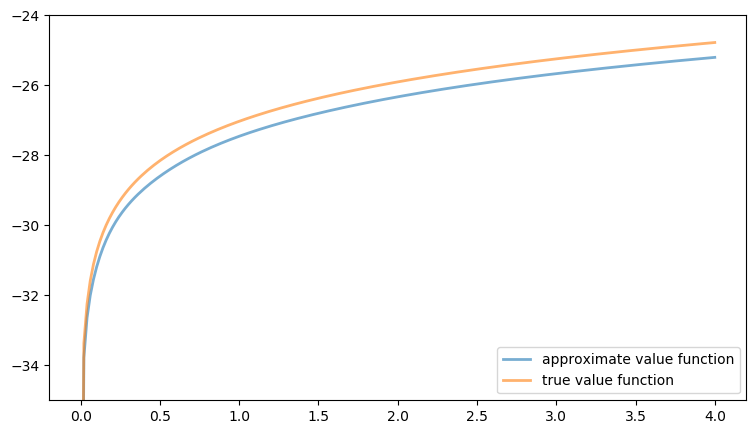

In [24]:
fig, ax = subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid_y, res.V, lw=2, alpha=0.6, label="approximate value function")
ax.plot(grid_y, v_star.(grid_y), lw=2, alpha=0.6, label="true value function")
ax.legend(loc="lower right")
show()

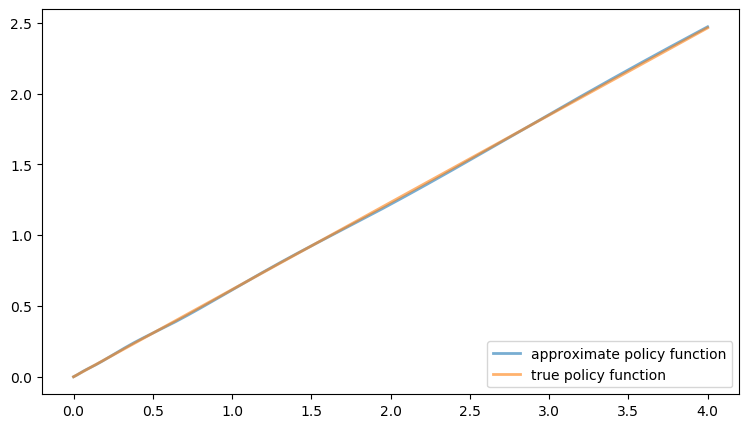

In [25]:
fig, ax = subplots(figsize=(9, 5))
ax.plot(grid_y, res.X, lw=2, alpha=0.6, label="approximate policy function")
ax.plot(grid_y, c_star.(grid_y), lw=2, alpha=0.6, label="true policy function")
ax.legend(loc="lower right")
show()

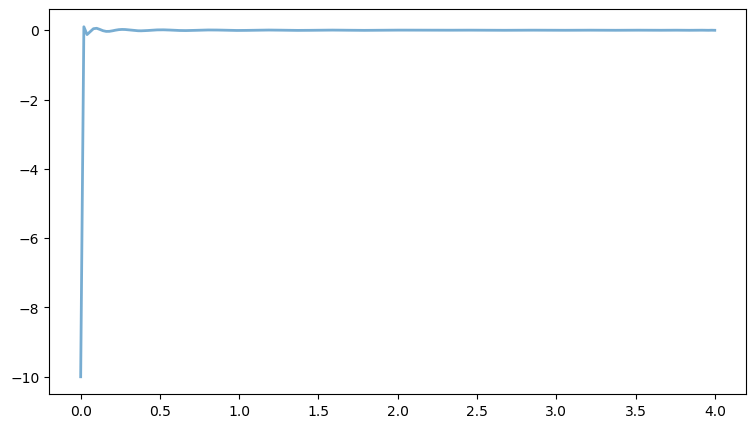

In [26]:
fig, ax = subplots(figsize=(9, 5))
ax.plot(grid_y, res.resid, lw=2, alpha=0.6, label="residual")
show()

## Simulate the controlled Markov process

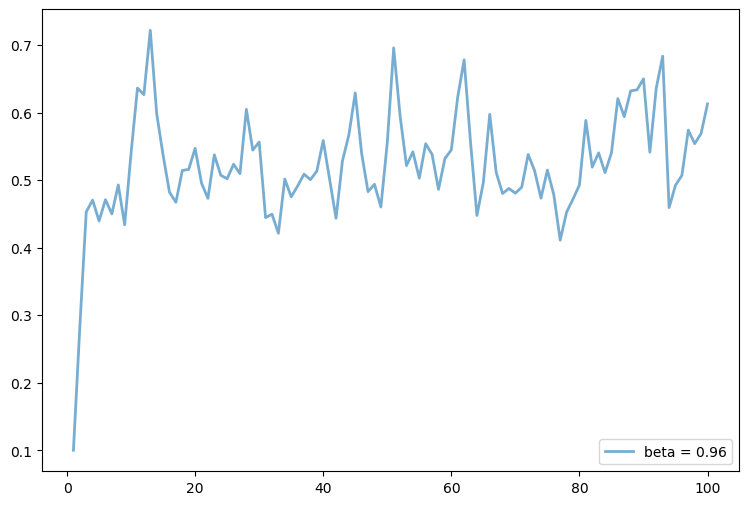

In [27]:
s_init = 0.1
ts_length = 100
y = simulate(res, s_init, ts_length)

fig, ax = subplots(figsize=(9, 6))
ax.plot(1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
ax.legend(loc="lower right")
show()

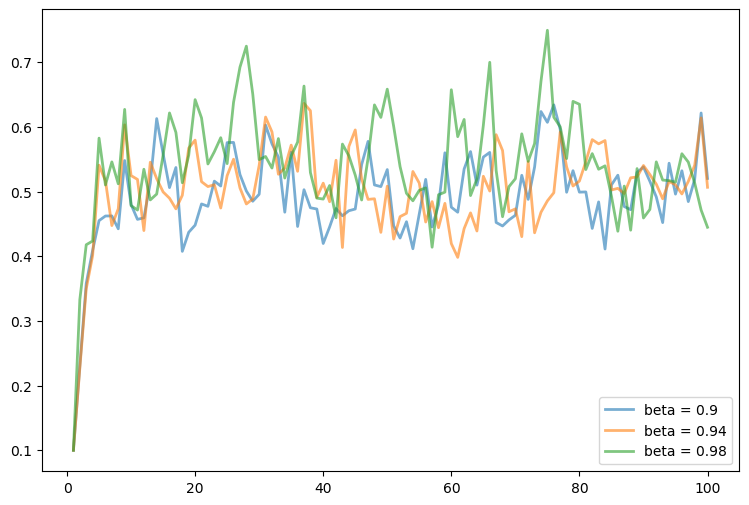

In [28]:
fig, ax = subplots(figsize=(9, 6))

for beta in (0.9, 0.94, 0.98)
    cdp.discount = beta
    res = solve(cdp, verbose=0)
    set_eval_nodes!(res, grid_y)
    y = simulate(res, s_init, ts_length)
    ax.plot(1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
end

ax.legend(loc="lower right")
show()

In [29]:
@code_warntype simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)

Variables
  #self#::Core.Compiler.Const(QuantEcon.simulate!, false)
  rng::MersenneTwister
  s_path::Array{Float64,1}
  res::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
  s_init::Float64
  #10::ContinuousDPs.var"#10#11"
  ts_length::Int64
  cdf::Array{Float64,1}
  r::Array{Float64,1}
  e_ind::Array{Int64,1}
  @_11::Union{Nothing, Tuple{Int64,Int64}}
  basis::Basis{1,Tuple{LinParams{Array{Float64,1}}}}
  X_interp::Interpoland{Basis{1,Tuple{LinParams{Array{Float64,1}}}},Array{Float64,1},BasisMatrix{Tensor,SparseArrays.SparseMatrixCSC{Float64,Int64}}}
  s_ind_front::Tuple{}
  e_ind_tail::Tuple{}
  @_16::Union{Nothing, Tuple{Int64,Int64}}
  t@_17::Int64
  s::Float64
  x::Float64
  e::Float64
  t@_21::Int64

Body::Array{Float64,1}
1 ─       Core.NewvarNode(:(#10))
│         Core.NewvarNode(:(basis))
│         Core.NewvarNode(:(X_interp))
│         Core.NewvarNode(:(s_ind_front))
│         Core.NewvarNode(:(e_ind_tail))
│         Core.NewvarNode(:(@_16))
│   %7  = C

In [30]:
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init);

  0.023478 seconds (52.65 k allocations: 2.807 MiB)
  0.000179 seconds (3.54 k allocations: 285.094 KiB)
  0.000163 seconds (3.54 k allocations: 285.094 KiB)
